# Collecting Texts from authors

**The aim of this notebook is to scrape the text data needed for this project.**

The research area of this project focuses on the novels of well-known French authors of the 19th and 20th centuries.

For each author selected, this notebook will scrape excerpts of around 1,500 words from all their novels available in French on The Gutenberg Project - a vast collection of free ebooks.

A list of authors corresponding to the above criteria has been drawn up in advance, based on sources such as the Universal Encyclopaedia. This list corresponds to ***authors.csv***.

The first part of this notebook - **listing usable novels** - will consist in the creation of 2 new files:
- ***books.csv***: a database containing a list of novels that can be found in French on Project Gutenberg for each author, with metadata for each book srapped from the Project Gutenberg site or labeled by an LLM.
- ***final_authors.csv***: a database updating the list of authors according to the accessibility of their works on the Project Gutenberg website and with labels taken from those of books.csv

The second part of this notebook - **scraping excerpts** - will consist in the creation of ***excerpts.parquet***, a database containing the clean excerpts (no title, no headings, no pre/post novel parts, no overlapping between chapters, no very short dialogues) labeled with the author and the novel its from. ***final_authors.csv*** is also updated with information about the number of excerpts that were successfully scrapped.

Note that to run the parts that include LLM labeling, a .env file with an openai api key is required.

May 2025 - Hadrien Strichard

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import requests # for web scraping
from bs4 import BeautifulSoup # for web scraping
import os
import re # for regex
import unicodedata
import openai #for llm labeling
import json
from tqdm import tqdm # for progress bar

## Part 1 : Listing usable novels

### Loading the list of potential authors

In [2]:
# Read authors.csv 
authors_df = pd.read_csv('../Data/authors.csv', delimiter=';', encoding='MacRoman')

# Correcting the column names and formats
authors_df['birth_date'] = pd.to_datetime(authors_df['Année de naissance'], format='%Y')
authors_df['death_date'] = pd.to_datetime(authors_df['Année de mort'], format='%Y')
authors_df.rename(columns={'Nom': 'Name'}, inplace=True)
authors_df.drop(['Année de naissance', 'Année de mort'], axis=1, inplace=True)

authors_df.head()

,Name,birth_date,death_date
0,Germaine de Staël,1766-01-01,1817-01-01
1,François-René de Chateaubriand,1768-01-01,1848-01-01
2,Charles Nodier,1780-01-01,1844-01-01
3,Stendhal,1783-01-01,1842-01-01
4,Alfred de Vigny,1797-01-01,1863-01-01


In [3]:
authors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Name        85 non-null     object        
 1   birth_date  85 non-null     datetime64[ns]
 2   death_date  77 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 2.1+ KB


The missing values in the death_date columns are due to some authors in the list being still alive

### Defining required functions

NB : Each function was tested with a few authors, Marcel Proust is here always taken as example.

**1. Getting a list of books for an author**

In [4]:
def search_books_by_author(author_name):
    """
    Search for books by a specific author on Project Gutenberg.

    Parameters:
    - author_name (str): The name of the author to search for.

    Returns:
    - books (list of tuples): A list of (title, link) tuples for each book found.
    """
    
    base_url = "https://www.gutenberg.org"
    # Construct the search URL by joining the author's name with '+' for the query
    search_url = f"{base_url}/ebooks/search/?query={'+'.join(author_name.split())}"

    books = []
    
    print(f"Searching for books by {author_name}...")

    while True:
        response = requests.get(search_url)
        soup = BeautifulSoup(response.content, "html.parser")

        # Extract book entries from the current page
        for li in soup.select(".booklink"):
            title = li.select_one(".title").text.strip()
            link = base_url + li.a["href"]
            books.append((title, link))

        # Look for a "Next" button to paginate through results
        next_button = soup.select_one("a[title='Go to the next page of results.']")
        if next_button:
            search_url = base_url + next_button["href"]
        else:
            break

    return books


In [5]:
# Testing search_books_by_author()

print(len(search_books_by_author('Marcel Proust')))
print(search_books_by_author('Marcel Proust'))

Searching for books by Marcel Proust...
27
Searching for books by Marcel Proust...
[('Du côté de chez Swann (French)', 'https://www.gutenberg.org/ebooks/2650'), ("Swann's Way", 'https://www.gutenberg.org/ebooks/7178'), ('Within a Budding Grove', 'https://www.gutenberg.org/ebooks/63532'), ("A l'ombre des jeunes filles en fleurs - Première partie (French)", 'https://www.gutenberg.org/ebooks/2998'), ("A l'ombre des jeunes filles en fleurs — Deuxième partie (French)", 'https://www.gutenberg.org/ebooks/2999'), ('Les plaisirs et les jours (French)', 'https://www.gutenberg.org/ebooks/58698'), ('The doctor looks at literature :  Psychological studies of life and letters', 'https://www.gutenberg.org/ebooks/75230'), ('La Prisonnière (Sodome et Gomorrhe III) (French)', 'https://www.gutenberg.org/ebooks/60720'), ('The Guermantes Way', 'https://www.gutenberg.org/ebooks/73425'), ('The writing of fiction', 'https://www.gutenberg.org/ebooks/72446'), ("A l'ombre des jeunes filles en fleurs — Troisième 

**2. Labelling and scrapping metadata about each book**

In [6]:
def normalize_author(raw_author):
    """
    Normalize an author's name from Project Gutenberg format to match the format
    used in authors.csv (e.g., 'Chateaubriand, François-René, vicomte de, 1768-1848' -> 'François-René de Chateaubriand').

    Parameters:
    - raw_author (str): Author name string from Project Gutenberg.

    Returns:
    - str: Normalized name in the format 'Firstname Lastname', including particles like 'de'.
    """

    # Delete dates
    raw_author = re.sub(r",\s*\d{4}-\d{4}", "", raw_author)

    # Delete noble titles
    raw_author = re.sub(r",?\s*(vicomte|comte|duc|marquis|baron|chevalier)(\s+de)?", "", raw_author, flags=re.IGNORECASE)

    parts = [part.strip() for part in raw_author.split(",")]

    # From the format "Lastname, Firstname" to "Firstname Lastname"
    if len(parts) == 2:
        lastname, firstname = parts[0], parts[1]

    elif len(parts) > 2:
        lastname = parts[0]
        firstname = parts[1]

        # Manage cases where the first name contains parentheses
        match = re.search(r"\(([^)]+)\)", firstname)
        if match:
            firstname = match.group(1)

    else:
        return raw_author.strip()

    # Managing cases where the first name contains a particle
    particle_match = re.match(r"^(de|du|d'|des|la|le)\s+(.*)", lastname, flags=re.IGNORECASE)
    if particle_match:
        lastname = f"{particle_match.group(1)} {particle_match.group(2)}"

    return f"{firstname} {lastname}"


In [ ]:
client = openai.OpenAI()

def label_book_with_llm(title, author):
    
    """
    Use a lightweight OpenAI language model to label a book with metadata.

    Given a book title and author, the function prompts the LLM (using GPT-4.1-nano)
    to:
    - Determine if it's a novel
    - Identify up to 5 main literary genres
    - Classify the author's literary movement
    - Estimate the original publication year

    Parameters:
    - title (str): Title of the book
    - author (str): Author of the book

    Returns:
    - dict: A JSON-like dictionary with keys:
        - "roman" (bool)
        - "genre" (list of str)
        - "mouvement" (list of str)
        - "date" (int or str)
    """
    # Prompt in French to align with the literary domain and source material.
    # Guides the LLM through structured steps and provides two concrete examples.
    
    prompt = f"""
    Tu es un expert en littérature française. Voici une œuvre :
    - Titre : {title}
    - Auteur : {author}

    Réponds aux questions suivantes :
    1. Est-ce un roman ? (True/False)
    2. Quel est le genre principal du roman ? Choisis 1 à 5 genres dans cette liste (utilise plus qu'un genre seulement si c'est réellement pertinent) : 
        "Policier / Polar",
        "Science-Fiction",
        "Fantastique",
        "Fantaisie",
        "Épistolaire",
        "Historique",
        "Biographique / Exofiction",
        "Autobiographique / Autofiction",
        "Psychologique",
        "Philosophique",
        "Social / Moeurs",
        "Amour",
        "Bildungsroman",
        "Gothique",
        "Dystopique/Utopique",
        "Aventure",
        "Satirique",
        "Post-Apocalyptique",
        "Érotique",
        "Cape et d’épée"
    3. À quel mouvement littéraire appartient l’auteur parmi cette liste? N'en met pas plus que deux. Tu remarqueras la catégorie inclassable pour des auteurs comme Proust.
        "Romantisme",
        "Réalisme",
        "Naturalisme",
        "Parnasse",
        "Symbolisme",
        "Absurde",
        "Surréalisme",
        "Oulipo",
        "Futurisme",
        "Dadaïsme",
        "Existentialisme",
        "Objectivisme",
        "Beat Generation",
        "Nouveau Roman",
        "Réalisme magique",
        "Négritude",
        "Prolétarien",
        "Proto SF",
        "Décadentisme",
        "Roman Moderne",
        "Catholicisme littéraire"

    4. Quelle est l’année de première parution de cette œuvre ?

    Réponds en JSON :
    {{
        "roman": ...,
        "genre": [...],
        "mouvement": [...],
        "date": ...
    }}
    
    Par exemple pour "Harry Potter à l'école des sorciers" de JK Rowling, tu pourrais répondre :
    {{
        "roman": true,
        "genre": ["Fantastique", "Aventure", "Bildungsroman"],
        "mouvement": ["inclassable"],
        "date": 1997
    }}
    
    Autre exemple, pour "Les mémoires d'Hadrien" de Yourcenar :
    {{
        "roman": true,
        "genre": ["Historique", "Biographique / Exofiction", "Épistolaire", "Philosophique"],
        "mouvement": ["inclassable"],
        "date": 1951
        }}
        
    Si tu ne connais pas l'oeuvre, suppose que ce n'est pas une roman.
    """
    
    # Send the prompt to OpenAI's lightweight model (gpt-4.1-nano)
    response = client.chat.completions.create(
        model="gpt-4.1-nano-2025-04-14",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
    )

    content = response.choices[0].message.content
    
    try:
        return json.loads(content)
    except json.JSONDecodeError as e:
        print(f"\n⚠️ JSON parsing error for '{title}' by '{author}': {e}")
        print("Raw content returned by LLM:")
        print(content)
        return {
            "roman": False,
            "genre": [],
            "mouvement": ["inclassable"],
            "date": None
        }

In [8]:
# Testing label_book_with_llm()

label_book_with_llm("A la recherche du temps perdu v1 - Du Côté de chez Swann", "Marcel Proust")

{'roman': True,
 'genre': ['Autobiographique / Autofiction', 'Analyse'],
 'mouvement': ['inclassable'],
 'date': 1913}

In [9]:
def extract_metadata(book_list):
    
    """
    Extract metadata from a list of Project Gutenberg book URLs,
    enrich the data using a language model, and return it as a DataFrame.

    Parameters:
    - book_list (list of tuples): Each tuple contains (title, url) of a book.

    Returns:
    - pd.DataFrame: DataFrame with structured metadata including LLM-enriched fields.
    """
    
    metadata = []
    count = 1

    for title, url in book_list:
        progress = count / len(book_list) * 100
        if count % 10 == 0:
            print(f"Progress: {progress:.2f}% ({count}/{len(book_list)})")
        count += 1
        response = requests.get(url)
        soup = BeautifulSoup(response.content, "html.parser")
        table = soup.find("table", {"class": "bibrec"})

        data = {
            "Author": None,
            "Title": None,
            "Language": None,
            "EBook-No": None,
            "URL": url,
            "Roman": None,
            "Genres": None,
            "Mouvement": None,
            "Date": None
        }

        # Scraping classique
        if table:
            for row in table.find_all("tr"):
                header_cell = row.find("th")
                value_cell = row.find("td")

                if not header_cell or not value_cell:
                    continue

                header = header_cell.get_text(strip=True)
                value = value_cell.get_text(strip=True)

                if header == "Author":
                    normalized_author = normalize_author(value)
                    data["Author"] = normalized_author
                elif header == "Title":
                    data["Title"] = value
                elif header == "Language":
                    data["Language"] = value
                elif header == "EBook-No.":
                    data["EBook-No"] = value

        # Vérifie que les champs requis sont présents avant d'appeler le LLM
        if data["Author"] and data["Title"]:
            llm_result = label_book_with_llm(data["Title"], data["Author"])
            data["Roman"] = llm_result.get("roman")
            data["Genres"] = ", ".join(llm_result.get("genre", []))
            data["Mouvement"] = ", ".join(llm_result.get("mouvement", []))
            data["Date"] = llm_result.get("date")

        metadata.append(data)

    df = pd.DataFrame(metadata)
    return df

In [10]:
# Testing extract_metadata()

extract_metadata(search_books_by_author('Marcel Proust'))

Searching for books by Marcel Proust...
Progress: 37.04% (10/27)
Progress: 74.07% (20/27)


,Author,Title,Language,EBook-No,URL,Roman,Genres,Mouvement,Date
0,Marcel Proust,Du côté de chez Swann,French,2650,https://www.gutenberg.org/ebooks/2650,True,"Autobiographique / Autofiction, Analyse",inclassable,1913.0
1,Marcel Proust,Swann's Way,English,7178,https://www.gutenberg.org/ebooks/7178,True,"Analyse, Autobiographique / Autofiction",inclassable,1913.0
2,Marcel Proust,Within a Budding Grove,English,63532,https://www.gutenberg.org/ebooks/63532,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
3,Marcel Proust,A l'ombre des jeunes filles en fleurs - Premiè...,French,2998,https://www.gutenberg.org/ebooks/2998,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
4,Marcel Proust,A l'ombre des jeunes filles en fleurs — Deuxiè...,French,2999,https://www.gutenberg.org/ebooks/2999,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
5,Marcel Proust,Les plaisirs et les jours,French,58698,https://www.gutenberg.org/ebooks/58698,True,"Analyse, Autobiographique / Autofiction",inclassable,1922.0
6,Joseph Collins,The doctor looks at literature : Psychologica...,English,75230,https://www.gutenberg.org/ebooks/75230,False,,,NaN
7,Marcel Proust,La Prisonnière (Sodome et Gomorrhe III),French,60720,https://www.gutenberg.org/ebooks/60720,True,"Analyse, Érotique",inclassable,1929.0
8,Marcel Proust,The Guermantes Way,English,73425,https://www.gutenberg.org/ebooks/73425,True,Analyse,inclassable,1925.0
9,Edith Wharton,The writing of fiction,English,72446,https://www.gutenberg.org/ebooks/72446,False,,,NaN


**3. Filtering the books to match project's criterion**

In [11]:
def filter_metadata(df, target_author):
    """
    Filter the metadata DataFrame to retain only relevant entries for analysis.

    Steps:
    1. Keep only rows where the work is identified as a novel.
    2. Keep only works written in French.
    3. Remove duplicate titles.
    4. Keep only books written by the target author (case-insensitive, partial match allowed).

    Parameters:
    - df (pd.DataFrame): The full metadata DataFrame.
    - target_author (str): The author name to filter by.

    Returns:
    - pd.DataFrame: A cleaned and filtered DataFrame focused on the target author's novels.
    """
    
    if not df.empty:
        # 1. Filter to include only novels (as determined by LLM)
        df = df[df["Roman"] == True]

        # 2. Retain only books written in French
        df = df[df["Language"] == "French"]

        # 3. Remove duplicate entries based on the title
        df = df.drop_duplicates(subset="Title")

        # 4. Keep only rows where the author's name contains the target_author string (case-insensitive)
        df = df[df["Author"].str.lower().str.contains(target_author.lower())]

    return df.reset_index(drop=True)

In [12]:
# Testing filter_metadata()

filter_metadata(extract_metadata(search_books_by_author('Marcel Proust')), 'Marcel Proust')

Searching for books by Marcel Proust...
Progress: 37.04% (10/27)
Progress: 74.07% (20/27)


,Author,Title,Language,EBook-No,URL,Roman,Genres,Mouvement,Date
0,Marcel Proust,Du côté de chez Swann,French,2650,https://www.gutenberg.org/ebooks/2650,True,"Autobiographique / Autofiction, Analyse",inclassable,1913.0
1,Marcel Proust,A l'ombre des jeunes filles en fleurs - Premiè...,French,2998,https://www.gutenberg.org/ebooks/2998,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
2,Marcel Proust,A l'ombre des jeunes filles en fleurs — Deuxiè...,French,2999,https://www.gutenberg.org/ebooks/2999,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
3,Marcel Proust,Les plaisirs et les jours,French,58698,https://www.gutenberg.org/ebooks/58698,True,"Analyse, Autobiographique / Autofiction",inclassable,1922.0
4,Marcel Proust,La Prisonnière (Sodome et Gomorrhe III),French,60720,https://www.gutenberg.org/ebooks/60720,True,"Analyse, Autobiographique / Autofiction",inclassable,1924.0
5,Marcel Proust,A l'ombre des jeunes filles en fleurs — Troisi...,French,3000,https://www.gutenberg.org/ebooks/3000,True,"Autobiographique / Autofiction, Analyse",inclassable,1919.0
6,Marcel Proust,Le temps retrouvé Tome 1 (de 2) : À la recher...,French,74090,https://www.gutenberg.org/ebooks/74090,True,"Autobiographique / Autofiction, Analyse",inclassable,1927.0
7,Marcel Proust,Pastiches et mélanges,French,64145,https://www.gutenberg.org/ebooks/64145,True,Analyse,inclassable,1919.0
8,Marcel Proust,Sodome et Gomorrhe - Première partie,French,15288,https://www.gutenberg.org/ebooks/15288,True,Analyse,inclassable,1936.0
9,Marcel Proust,Le temps retrouvé Tome 2 (de 2) : À la recher...,French,74091,https://www.gutenberg.org/ebooks/74091,True,"Autobiographique / Autofiction, Analyse",inclassable,1927.0


**4. Regrouping every function in one get method**

In [13]:
def get_books(author):
    """
    Get a list of labeled books by a specific author from Project Gutenberg.

    Parameters:
    - author (str): The author's name.

    Returns:
    - pd.DataFrame: A DataFrame containing the filtered metadata for the author's books.
    """
    
    return filter_metadata(extract_metadata(search_books_by_author(author)), author)

### Creating books.csv and final_authors.csv

**1. Generating books_df**

In [14]:
# /!\ This function will take a long time to run, as it scrapes the web and calls the LLM for each book.

books_list = []
count = 1

for author in authors_df["Name"]:
#    if count > 34:     Limit to the first 34 authors for testing
#        break
    print(f'Author {count} out of {len(authors_df)}')
    df = get_books(author)
    if not df.empty:
        books_list.append(df)
        print(f"n available books for {author} = {len(df)}")
    else:
        print(f"No available book for {author}")
    count += 1

books_df = pd.concat(books_list, ignore_index=True)


Author 1 out of 85
Searching for books by Germaine de Staël...
Progress: 83.33% (10/12)
No available book for Germaine de Staël
Author 2 out of 85
Searching for books by François-René de Chateaubriand...
Progress: 50.00% (10/20)
Progress: 100.00% (20/20)
No available book for François-René de Chateaubriand
Author 3 out of 85
Searching for books by Charles Nodier...
Progress: 58.82% (10/17)
n available books for Charles Nodier = 2
Author 4 out of 85
Searching for books by Stendhal...
Progress: 30.30% (10/33)
Progress: 60.61% (20/33)
Progress: 90.91% (30/33)
n available books for Stendhal = 6
Author 5 out of 85
Searching for books by Alfred de Vigny...
Progress: 55.56% (10/18)
n available books for Alfred de Vigny = 3
Author 6 out of 85
Searching for books by Honoré de Balzac...
Progress: 5.24% (10/191)
Progress: 10.47% (20/191)
Progress: 15.71% (30/191)
Progress: 20.94% (40/191)
Progress: 26.18% (50/191)
Progress: 31.41% (60/191)
Progress: 36.65% (70/191)
Progress: 41.88% (80/191)
Progr

In [15]:
books_df.head()

,Author,Title,Language,EBook-No,URL,Roman,Genres,Mouvement,Date
0,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,French,18083,https://www.gutenberg.org/ebooks/18083,True,"Fantastique, Gothique, Romantique",Romantisme,1849.0
1,Charles Nodier,Jean Sbogar,French,64289,https://www.gutenberg.org/ebooks/64289,True,Historique,inclassable,1835.0
2,Stendhal,Le rouge et le noir: chronique du XIXe siècle,French,798,https://www.gutenberg.org/ebooks/798,True,"Historique, Analyse",Réalisme,1830.0
3,Stendhal,La Chartreuse De Parme,French,796,https://www.gutenberg.org/ebooks/796,True,"Historique, Amour, Aventure",Réalisme,1839.0
4,Stendhal,"Lucien Leuwen; ou, l'Amarante et le Noir. Tome...",French,60030,https://www.gutenberg.org/ebooks/60030,True,"Historique, Amour",Réalisme,1855.0


In [16]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Author     301 non-null    object
 1   Title      301 non-null    object
 2   Language   301 non-null    object
 3   EBook-No   301 non-null    object
 4   URL        301 non-null    object
 5   Roman      301 non-null    object
 6   Genres     301 non-null    object
 7   Mouvement  301 non-null    object
 8   Date       300 non-null    object
dtypes: object(9)
memory usage: 21.3+ KB


**2. Updating the list of authors**



In [17]:
# 1. Keep only authors who have at least one valid novel in books_df
valid_authors = books_df["Author"].unique()
final_authors_df = authors_df[authors_df["Name"].isin(valid_authors)].copy()

# 2. Add 'n_books' column: count of valid novels per author
book_counts = books_df["Author"].value_counts().rename("n_books")
final_authors_df = final_authors_df.merge(book_counts, how="left", left_on="Name", right_index=True)

# 3. Add 'Mouvement' column: most frequent literary movement across the author's books
dominant_movement = (
    books_df.groupby("Author")["Mouvement"]
    .agg(lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else None)
    .rename("Mouvement")
)
final_authors_df = final_authors_df.merge(dominant_movement, how="left", left_on="Name", right_index=True)

# 4. Add 'Genres' column: unique, deduplicated genres across all books of the author
def unique_genres(genres_series):
    genres = set()
    for entry in genres_series:
        if pd.notna(entry):
            genres.update(g.strip() for g in entry.split(","))
    return ", ".join(sorted(genres))

author_genres = (
    books_df.groupby("Author")["Genres"]
    .agg(unique_genres)
    .rename("Genres")
)
final_authors_df = final_authors_df.merge(author_genres, how="left", left_on="Name", right_index=True)

# 5. Reset index to clean up after filtering
final_authors_df.reset_index(drop=True, inplace=True)


In [18]:
final_authors_df.head()

,Name,birth_date,death_date,n_books,Mouvement,Genres
0,Charles Nodier,1780-01-01,1844-01-01,2,Romantisme,"Fantastique, Gothique, Historique, Romantique"
1,Stendhal,1783-01-01,1842-01-01,6,Réalisme,"Amour, Analyse, Aventure, Historique"
2,Alfred de Vigny,1797-01-01,1863-01-01,3,Romantisme,"Amour, Analyse, Aventure, Historique"
3,Honoré de Balzac,1799-01-01,1850-01-01,16,Réalisme,"Amour, Analyse, Autobiographique / Autofiction..."
4,Alexandre Dumas,1802-01-01,1870-01-01,18,inclassable,"Amour, Aventure, Fantaisie, Historique"


In [19]:
final_authors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Name        29 non-null     object        
 1   birth_date  29 non-null     datetime64[ns]
 2   death_date  29 non-null     datetime64[ns]
 3   n_books     29 non-null     int64         
 4   Mouvement   29 non-null     object        
 5   Genres      29 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 1.5+ KB


**3. Save books_df and final_authors_df**

In [20]:
books_df.to_csv("../Data/books.csv", index=False)
final_authors_df.to_csv("../Data/final_authors.csv", index=False)

## Part 2: Scrapping excerpts

### Defining functions to scrape and process a raw text into clean regular excerpts

**1. Scrapping a raw text**

In [21]:
def get_gutenberg_text_url(book_page_url):
    """
    Given the URL of a Gutenberg book page, find the best plain text (.txt) download link.
    Preference is given to the UTF-8 encoded version.
    """
    response = requests.get(book_page_url)
    soup = BeautifulSoup(response.content, "html.parser")

    # First, search for UTF-8 plain text download links
    for tr in soup.find_all("tr", {"typeof": "pgterms:file"}):
        a = tr.find("a", href=True)
        href = a['href']
        if href.endswith(".txt.utf-8"):
            return "https://www.gutenberg.org" + href

    # Fallback: if no UTF-8 version is found, look for any .txt file
    for tr in soup.find_all("tr", {"typeof": "pgterms:file"}):
        a = tr.find("a", href=True)
        href = a['href']
        if href.endswith(".txt"):
            return "https://www.gutenberg.org" + href

    # If no text link is found at all, return None
    return None

def download_gutenberg_text(book_page_url):
    """
    Downloads and returns the plain text content of a Gutenberg book
    given its main page URL.
    """
    text_url = get_gutenberg_text_url(book_page_url)
    if not text_url:
        raise ValueError(f"No .txt file found for {book_page_url}")

    response = requests.get(text_url)
    response.encoding = 'utf-8'  # Ensure proper decoding
    return response.text


In [22]:
# Testing download_gutenberg_text()

book_url = "https://www.gutenberg.org/ebooks/18083"
text_content = download_gutenberg_text(book_url)
print(text_content[:2000]) 

The Project Gutenberg eBook of Smarra ou les démons de la nuit: Songes romantiques
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Smarra ou les démons de la nuit: Songes romantiques

Author: Charles Nodier

Release date: March 30, 2006 [eBook #18083]

Language: French

Credits: Produced by www.ebooksgratuits.com and Chuck Greif


*** START OF THE PROJECT GUTENBERG EBOOK SMARRA OU LES DÉMONS DE LA NUIT: SONGES ROMANTIQUES ***




Produced by www.ebooksgratuits.com and Chuck Greif




Charles Nodier

SMARRA

ou

LES DÉMONS DE LA NUIT

(1821)




Table des matières


Préface de la premiè

**2. Cleaning text from headers, titles, etc.**

In [23]:
def normalize_text(text):
    """Normalize accents and case for comparison."""
    return unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8').lower()

def clean_gutenberg_text(raw_text):
    """
    Cleans Project Gutenberg text by removing metadata, titles, short paragraphs,
    short dialogues, and French chapter/section headings.

    Args:
        raw_text (str): Raw UTF-8 text.

    Returns:
        str: Cleaned text.
    """
    # Step 1: Trim metadata
    lines = raw_text.splitlines()
    if len(lines) < 460:
        raise ValueError("Text too short to trim metadata.")
    trimmed_text = '\n'.join(lines[100:-360])

    # Step 2: Split into paragraphs
    paragraphs = re.split(r'\n\s*\n', trimmed_text)
    cleaned_paragraphs = []

    dialogue_markers = ('"', '«', '-', '–')

    # Keywords to remove if at the beginning of a paragraph
    heading_keywords = [
        "chapitre", "préface", "postface", "table des matières",
        "chronologie", "avant-propos", "introduction", 
        "épilogue", "conclusion", "annexe", "appendice"
    ]

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        # Normalize for heading comparison
        first_line = para.splitlines()[0].strip()
        normalized_first = normalize_text(first_line)

        # Skip if it's a chapter heading or similar section title
        if re.match(r'^chapitre\s+\w+', normalized_first, re.IGNORECASE):
            continue
        if any(normalized_first.startswith(keyword) for keyword in heading_keywords):
            continue

        # Break into lines
        lines_in_para = [line.strip() for line in para.splitlines() if line.strip()]
        line_count = len(lines_in_para)

        # Remove very short paragraphs (likely titles or noise)
        if line_count == 1 and len(lines_in_para[0].split()) < 10:
            continue

        # Remove short dialogues
        first = lines_in_para[0]
        second = lines_in_para[1] if line_count > 1 else ""

        if first.startswith(dialogue_markers):
            if line_count <= 2 or second.startswith(dialogue_markers):
                continue

        cleaned_paragraphs.append(para)

    return '\n\n'.join(cleaned_paragraphs)


In [24]:
# Testing clean_gutenberg_text()
cleaned_text = clean_gutenberg_text(text_content)
print(cleaned_text)

n'est souvent déterminée que par un mot. En ce point même, cependant, il
n'a fait que se conformer au caprice piquant de la nature, qui se joue à
nous faire parcourir dans la durée d'un seul rêve, plusieurs fois
interrompu par des épisodes étrangers à son objet, tous les
développements d'une action régulière, complète et plus ou moins
vraisemblable.

Les personnes qui ont lu Apulée s'apercevront facilement que la fable du
premier livre de L'_Âne d'or_ de cet ingénieux conteur a beaucoup de
rapports avec celle-ci, et qu'elles se ressemblent par le fond presque
autant qu'elles diffèrent par la forme. L'auteur paraît même avoir
affecté de solliciter ce rapprochement en conservant à son principal
personnage le nom de Lucius. Le récit du philosophe de Madaure et celui
du prêtre dalmate, cité par Fortis, tome I, page 65, ont en effet une
origine commune dans les chants traditionnels d'une contrée qu'Apulée
avait curieusement visitée, mais dont il a dédaigné de retracer le
caractère, ce qui n

**3. Paragraph segmentation**

In [25]:
def segment_into_paragraphs(text):
    """
    Splits the input text into paragraphs using blank lines as separators.

    Args:
        text (str): Cleaned text.

    Returns:
        list[str]: List of paragraph strings.
    """
    # Split on 1+ empty lines (which may include spaces or tabs)
    paragraphs = re.split(r'\n\s*\n', text)
    
    # Strip whitespace and remove any completely empty results
    return [p.strip() for p in paragraphs if p.strip()]



In [26]:
# Testing split_into_clean_paragraphs()
cleaned_paragraphs = segment_into_paragraphs(cleaned_text)
print(len(cleaned_paragraphs))
print(cleaned_paragraphs[0])
print(cleaned_paragraphs[-1])

179
n'est souvent déterminée que par un mot. En ce point même, cependant, il
n'a fait que se conformer au caprice piquant de la nature, qui se joue à
nous faire parcourir dans la durée d'un seul rêve, plusieurs fois
interrompu par des épisodes étrangers à son objet, tous les
développements d'une action régulière, complète et plus ou moins
vraisemblable.
Il a traduit des ouvrages étrangers et rédigé de nombreuses préfaces,
agissant ou non comme éditeur. Les douze volumes d'Oeuvres Complètes de
Charles Nodier, qu'il a lui-même assemblés, écartent plusieurs de ses
textes. Par exemple, son essai autobiographique intitulé «Moi-même
«écrit en 1799 ne sera publié qu'en 1922. (Il s'agit d'une fantaisie!)
Ses contes (pour adultes, dans la majorité des cas.) ont fait l'objet de
plusieurs éditions depuis 1841, à divers titres et selon des choix
précis: Contes fantastiques, Contes de la Veillée, Contes du père Nodier
et le reste.


**4. From paragraphs to excerpts**

In [27]:
def create_excerpts_by_paragraphs(paragraphs, target_word_count=1500, tolerance=0.1):
    """
    Groups paragraphs into excerpts of approximately `target_word_count` words.
    Ensures excerpts start and end at paragraph boundaries.

    Args:
        paragraphs (list[str]): List of paragraphs.
        target_word_count (int): Approximate number of words per excerpt.
        tolerance (float): Acceptable deviation (e.g., 0.1 for ±10%).

    Returns:
        list[str]: List of excerpt strings.
    """
    excerpts = []
    current_excerpt = []
    current_word_count = 0

    min_words = int(target_word_count * (1 - tolerance))
    max_words = int(target_word_count * (1 + tolerance))

    for para in paragraphs:
        para_word_count = len(para.split())
        
        # If adding this paragraph would exceed the max and current is over min, finalize excerpt
        if current_word_count + para_word_count > max_words and current_word_count >= min_words:
            excerpts.append('\n\n'.join(current_excerpt))
            current_excerpt = [para]
            current_word_count = para_word_count
        else:
            current_excerpt.append(para)
            current_word_count += para_word_count

    # Add the last excerpt if there's content left
    if current_excerpt:
        excerpts.append('\n\n'.join(current_excerpt))

    return excerpts


In [28]:
# Testing build_text_excerpts()
excerpts = create_excerpts_by_paragraphs(cleaned_paragraphs)
print(f"Number of excerpts: {len(excerpts)}")
print(f"Excerpt 1:\n{excerpts[0]}")
print(len(excerpts[0].split()))

Number of excerpts: 11
Excerpt 1:
n'est souvent déterminée que par un mot. En ce point même, cependant, il
n'a fait que se conformer au caprice piquant de la nature, qui se joue à
nous faire parcourir dans la durée d'un seul rêve, plusieurs fois
interrompu par des épisodes étrangers à son objet, tous les
développements d'une action régulière, complète et plus ou moins
vraisemblable.

Les personnes qui ont lu Apulée s'apercevront facilement que la fable du
premier livre de L'_Âne d'or_ de cet ingénieux conteur a beaucoup de
rapports avec celle-ci, et qu'elles se ressemblent par le fond presque
autant qu'elles diffèrent par la forme. L'auteur paraît même avoir
affecté de solliciter ce rapprochement en conservant à son principal
personnage le nom de Lucius. Le récit du philosophe de Madaure et celui
du prêtre dalmate, cité par Fortis, tome I, page 65, ont en effet une
origine commune dans les chants traditionnels d'une contrée qu'Apulée
avait curieusement visitée, mais dont il a dédaigné 

**5. Regroup in one pipeline method**

In [29]:
def process_gutenberg_book(book_page_url, target_words=1500, tolerance=0.1):
    """
    Downloads and processes a Gutenberg book into excerpts.

    Args:
        book_page_url (str): URL to the Gutenberg book page.
        target_words (int): Approximate word count per excerpt.
        tolerance (float): Allowed deviation (e.g. 0.1 = ±10%).

    Returns:
        list[str]: List of excerpt strings.
    """
    raw_text = download_gutenberg_text(book_page_url)

    cleaned_text = clean_gutenberg_text(raw_text)
    paragraphs = segment_into_paragraphs(cleaned_text)
    excerpts = create_excerpts_by_paragraphs(paragraphs, target_word_count=target_words, tolerance=tolerance)

    return excerpts


In [30]:
# Testing process_gutenberg_book()
book_processed = process_gutenberg_book(book_url)
print(f"Number of excerpts: {len(book_processed)}")
print(f"Excerpt 1:\n{book_processed[0]}")
print(f"Word count in excerpt 1: {len(book_processed[0].split())}")

Number of excerpts: 11
Excerpt 1:
n'est souvent déterminée que par un mot. En ce point même, cependant, il
n'a fait que se conformer au caprice piquant de la nature, qui se joue à
nous faire parcourir dans la durée d'un seul rêve, plusieurs fois
interrompu par des épisodes étrangers à son objet, tous les
développements d'une action régulière, complète et plus ou moins
vraisemblable.

Les personnes qui ont lu Apulée s'apercevront facilement que la fable du
premier livre de L'_Âne d'or_ de cet ingénieux conteur a beaucoup de
rapports avec celle-ci, et qu'elles se ressemblent par le fond presque
autant qu'elles diffèrent par la forme. L'auteur paraît même avoir
affecté de solliciter ce rapprochement en conservant à son principal
personnage le nom de Lucius. Le récit du philosophe de Madaure et celui
du prêtre dalmate, cité par Fortis, tome I, page 65, ont en effet une
origine commune dans les chants traditionnels d'une contrée qu'Apulée
avait curieusement visitée, mais dont il a dédaigné 

### Scrapping and processing every book in the books_dataset and saving resulting datasets

In [31]:
# Defining needed functions for dataframes creation and processing

tqdm.pandas()

def build_excerpt_dataset(books_df):
    """
    Processes books and returns a DataFrame with one row per excerpt.

    Args:
        books_df (pd.DataFrame): Input metadata for books.

    Returns:
        pd.DataFrame: Each row is an excerpt with metadata.
    """
    all_excerpts = []

    for _, row in tqdm(books_df.iterrows(), total=len(books_df)):
        try:
            excerpts = process_gutenberg_book(row['URL'])
        except Exception as e:
            print(f"Failed to process book: {row['Title']} by {row['Author']}. Error: {e}")
            continue

        for i, excerpt in enumerate(excerpts):
            all_excerpts.append({
                'Author': row['Author'],
                'Title': row['Title'],
                'URL': row['URL'],
                'Excerpt_ID': f"{row['EBook-No']}_{i+1}",
                'Excerpt_Text': excerpt
            })

    return pd.DataFrame(all_excerpts)

def update_author_excerpt_counts(excerpt_df, final_authors_df):
    """
    Updates the final_authors_df with a new column: n_excerpts

    Args:
        excerpt_df (pd.DataFrame): Output of build_excerpt_dataset.
        final_authors_df (pd.DataFrame): Existing author metadata.

    Returns:
        pd.DataFrame: Updated author DataFrame.
    """
    excerpt_counts = excerpt_df.groupby('Author').size().reset_index(name='n_excerpts')

    # Merge while preserving original rows
    updated_authors_df = final_authors_df.merge(excerpt_counts, how='left', left_on='Name', right_on='Author')
    updated_authors_df['n_excerpts'] = updated_authors_df['n_excerpts'].fillna(0).astype(int)
    updated_authors_df.drop(columns=['Author'], inplace=True, errors='ignore')  # Clean up if needed

    return updated_authors_df


In [32]:
# Step 1: Process all books into excerpt-level dataset
excerpts_df = build_excerpt_dataset(books_df)

# Step 2: Update authors dataset with excerpt counts
updated_authors_df = update_author_excerpt_counts(excerpts_df, final_authors_df)

# Step 3: Save to Data folder
excerpts_df.to_parquet("../Data/excerpts_df.parquet", index=False)
updated_authors_df.to_csv("../Data/final_authors.csv", index=False)

print("✅ Done: Excerpts dataset and author metadata updated and saved.")

100%|██████████| 301/301 [12:20<00:00,  2.46s/it]


✅ Done: Excerpts dataset and author metadata updated and saved.


In [33]:
excerpts_df.head()

,Author,Title,URL,Excerpt_ID,Excerpt_Text
0,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_1,n'est souvent déterminée que par un mot. En ce...
1,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_2,Le reste ne me regarde point. J'ai dit de qui ...
2,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_3,"Les sylphes, tout étourdis du bruit de la veil..."
3,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_4,"À peine mes yeux sont fermés, à peine cesse la..."
4,Charles Nodier,Smarra ou les démons de la nuit: Songes romant...,https://www.gutenberg.org/ebooks/18083,18083_5,"C'est en vain que le jour s'éteindrait, tant q..."


In [34]:
excerpts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14755 entries, 0 to 14754
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Author        14755 non-null  object
 1   Title         14755 non-null  object
 2   URL           14755 non-null  object
 3   Excerpt_ID    14755 non-null  object
 4   Excerpt_Text  14755 non-null  object
dtypes: object(5)
memory usage: 576.5+ KB


In [35]:
updated_authors_df.head()

,Name,birth_date,death_date,n_books,Mouvement,Genres,n_excerpts
0,Charles Nodier,1780-01-01,1844-01-01,2,Romantisme,"Fantastique, Gothique, Historique, Romantique",38
1,Stendhal,1783-01-01,1842-01-01,6,Réalisme,"Amour, Analyse, Aventure, Historique",315
2,Alfred de Vigny,1797-01-01,1863-01-01,3,Romantisme,"Amour, Analyse, Aventure, Historique",121
3,Honoré de Balzac,1799-01-01,1850-01-01,16,Réalisme,"Amour, Analyse, Autobiographique / Autofiction...",1760
4,Alexandre Dumas,1802-01-01,1870-01-01,18,inclassable,"Amour, Aventure, Fantaisie, Historique",841


In [36]:
updated_authors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Name        29 non-null     object        
 1   birth_date  29 non-null     datetime64[ns]
 2   death_date  29 non-null     datetime64[ns]
 3   n_books     29 non-null     int64         
 4   Mouvement   29 non-null     object        
 5   Genres      29 non-null     object        
 6   n_excerpts  29 non-null     int64         
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 1.7+ KB


In [37]:
print(updated_authors_df['n_excerpts'].describe())

count      29.000000
mean      507.965517
std       655.051387
min         9.000000
25%        73.000000
50%       250.000000
75%       720.000000
max      2566.000000
Name: n_excerpts, dtype: float64


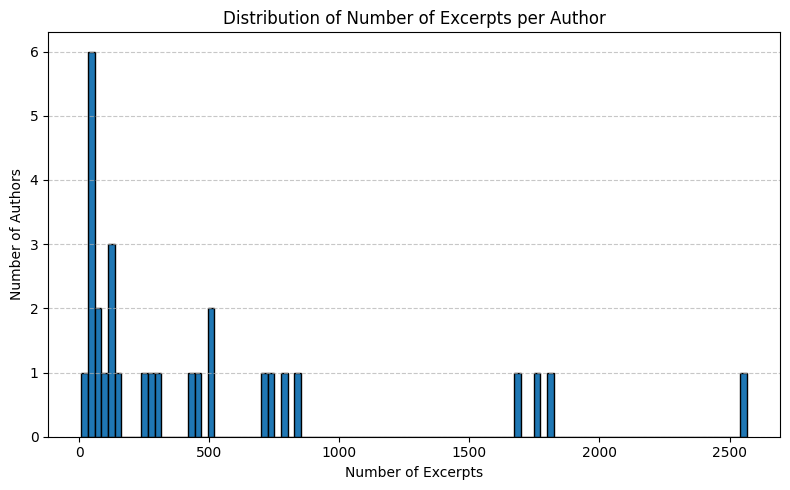

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(updated_authors_df["n_excerpts"], bins=100, edgecolor='black')
plt.title("Distribution of Number of Excerpts per Author")
plt.xlabel("Number of Excerpts")
plt.ylabel("Number of Authors")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [39]:
# Display authors with no excerpts
print(len(updated_authors_df))
print(updated_authors_df[['Name', 'n_excerpts']].sort_values(by='n_excerpts', ascending=True))

29
                    Name  n_excerpts
8       Alfred de Musset           9
27        Alain-Fournier          37
0         Charles Nodier          38
20          Jules Renard          38
25  Roger Martin du Gard          55
26      François Mauriac          57
28      Georges Bernanos          60
22            André Gide          73
24        Henri Barbusse          77
13          Jules Vallès         100
6        Prosper Mérimée         119
2        Alfred de Vigny         121
18     Guy de Maupassant         132
17        Octave Mirbeau         138
12     Ponson du Terrail         250
14       Alphonse Daudet         276
1               Stendhal         315
10      Gustave Flaubert         431
16        Anatole France         454
19          Paul Bourget         499
21        Romain Rolland         517
5            Victor Hugo         720
23         Marcel Proust         745
9             Paul Féval         797
4        Alexandre Dumas         841
11           Jules Verne        169